In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
%matplotlib inline

In [26]:
torch.__version__

'1.7.1'

In [27]:
torch.cuda.is_available()

False

In [28]:
print(torch.version.cuda)

None


# 与之前的区别在于改模型

In [2]:
transformation=transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_ds=datasets.MNIST(
    'data/',
    train=True,
    transform=transformation,
    download=True
)

Using downloaded and verified file: data/MNIST\raw\train-images-idx3-ubyte.gz
Extracting data/MNIST\raw\train-images-idx3-ubyte.gz


EOFError: Compressed file ended before the end-of-stream marker was reached

In [31]:
text_ds=datasets.MNIST(
    'data/',
    train=False,
    transform=transformation,
    download=True
)

In [4]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True)
text_dl=DataLoader(text_ds,batch_size=256) #验证数据集可以切片切的大一点，因为不用反向传播所以占用资源少

NameError: name 'train_ds' is not defined

In [33]:
img,label=next(iter(train_dl))  #取出一个批次的图片和标签

In [34]:
img.shape   #看一下这个批次的图片，因为批次是64，所以有64个
            #这四个参数分别是:batch_size,channel,high,width

torch.Size([64, 1, 28, 28])

# 在pytorch里图片的表示形式就是这样的[batch_size,channel,high,width]
 ToTensor会将channel这个维度放到第一维度，这是和其他方法最大的不同，如果是电脑中的普通图片则是长宽，channel（rgb通道）

In [35]:
image=img[0]  #取出一张图片

In [36]:
image.shape

torch.Size([1, 28, 28])

In [37]:
image=image.numpy() #想要绘图就得用ndarray

In [38]:
image=np.squeeze(image) #第一个维度channel没有用，去掉

In [39]:
image.shape

(28, 28)

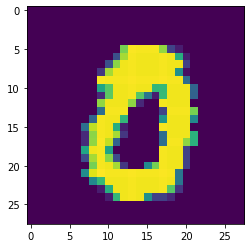

In [40]:
plt.imshow(image)

In [41]:
label[0]  #这张图片就是1

tensor(0)

In [42]:
def imshow(img):
    npimg=img.numpy()      #转化为numpy
    npimg=np.squeeze(npimg)#去除第一维度
    plt.imshow(npimg)      #显示图片

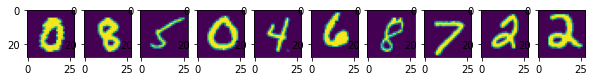

In [43]:
plt.figure(figsize=(10,1))             #创建画布
for i,img in enumerate(img[:10]):     #enumerate相当于是每次返回img[i]
    plt.subplot(1,10,i+1)             #创建10张子图  三个参数分别是一行十列绘制img的第几个（img[i]）
    imshow(img)

In [44]:
label[:10]

tensor([0, 8, 5, 0, 4, 6, 8, 7, 2, 2])

# 创建卷积模型

In [45]:
class Model(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv_1=nn.Conv2d(1,6,5)  #初始化一个2d的卷积层，适用在图像的特征提取
                                      # 第一个参数是输入的channel，所用的图像的可以看出是1 
                                      #第二个参数是要输出多少个channel，即你想要用多少个卷积核提取特征
                                      #第三个参数是卷积核的大小，定义了是几乘几的卷积核
       
        self.pool=nn.MaxPool2d((2,2))      #2d的最大池化层 大小是2*2 相当于池化一次长宽各减少一半（2*2的选出最大值就变成了1*1的）
        self.conv_2=nn.Conv2d(6,16,5)   #创建第二个卷积层，输入就是上一个卷积层的输出，输出设置的多一点
        
        
        self.linear_1=nn.Linear(16*4*4,256)  #大小为最后一个卷积层展平之后的大小,不一定是多少，所以下面用了print来打出提取完特征之后的大小
        #self.linear_2=nn.Linear(120,84)   #只用两个线性层得到输出就可以了（最后一层即全连接层）
        self.linear_2=nn.Linear(256,10)  
    def forward(self,input):
       #x=input.view(-1,28*28) #卷积模型不需要展平，保留图像的空间结构，卷积神经网络是在将所有特征提取完之后再展平
        x=F.relu(self.conv_1(input)) #卷积+激活
        x=self.pool(x)        #池化
        x=F.relu(self.conv_2(x))
        x=self.pool(x)  
        #print(x.size())    #看一下x具体多大方便定义第一个线性层的输入是多少  是torch.Size([64, 16, 4, 4])
        x=x.view(x.size(0),-1)#然后再根据x的大小展平
        x=F.relu(self.linear_1(x))
        x=self.linear_2(x) #因为是多分类，用的损失函数CrossEntropyLoss
                          #的输入是未激活的输出
        return x

In [46]:
model=Model()

In [47]:
model

Model(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear_1): Linear(in_features=256, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)

In [49]:
model(img[0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 1, 5, 5], but got 2-dimensional input of size [28, 28] instead

In [66]:
loss_fn=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model.parameters(),lr=0.01)

In [67]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0                              #总样本的个数
    running_loss=0
    for x,y in trainloader:    
        y_pred=model(x)
        loss=loss_fn(y_pred,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():                  #每一个y值进行一次计算，这是对训练数据
            y_pred=torch.argmax(y_pred,dim=1)
            correct+=(y_pred==y).sum().item()  #每一次正确的个数加到correct里
            total+=y.size(0)                   #每一批样本的个数
            running_loss+=loss.item()          #每一批样本的loss
        
        epoch_acc=correct/total                #正确率为正确个数除以样本个数
        epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
        
        
        text_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
        text_total=0                              
        text_running_loss=0
        with torch.no_grad():                  
             for x,y in textloader:    
                y_pred=model(x)
                loss=loss_fn(y_pred,y)
                y_pred=torch.argmax(y_pred,dim=1)
                text_correct+=(y_pred==y).sum().item() 
                text_total+=y.size(0)                   
                text_running_loss+=loss.item()
        
        epoch_text_acc=text_correct/text_total                
        epoch_text_loss=running_loss/len(textloader.dataset)  
        
        print('epoch: ',epoch,'loss: ',round(epoch_loss,3),
                              'accuracy: ',round(epoch_acc,3),
                              'text_loss: ',round(epoch_text_loss,3),
                              'text_accuracy: ',round(epoch_text_acc,3))
        return epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc  
                                                    #这样就会将每个epoch上的这些平均正确率和平均损失返回

In [71]:
epochs=50

In [69]:
train_loss=[] #如果想把值保存下来就创建这四个列表
train_acc=[]
text_loss=[]
text_acc=[]

In [72]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc =fit(epoch,model,train_dl,text_dl)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    text_loss.append(epoch_text_loss)
    text_acc.append(epoch_text_acc)

epoch:  0 loss:  0.0 accuracy:  0.734 text_loss:  0.0 text_accuracy:  0.864
epoch:  1 loss:  0.0 accuracy:  0.812 text_loss:  0.0 text_accuracy:  0.863
epoch:  2 loss:  0.0 accuracy:  0.828 text_loss:  0.0 text_accuracy:  0.875
epoch:  3 loss:  0.0 accuracy:  0.875 text_loss:  0.0 text_accuracy:  0.889
epoch:  4 loss:  0.0 accuracy:  0.891 text_loss:  0.0 text_accuracy:  0.888
epoch:  5 loss:  0.0 accuracy:  0.875 text_loss:  0.0 text_accuracy:  0.873
epoch:  6 loss:  0.0 accuracy:  0.906 text_loss:  0.0 text_accuracy:  0.875
epoch:  7 loss:  0.0 accuracy:  0.828 text_loss:  0.0 text_accuracy:  0.886
epoch:  8 loss:  0.0 accuracy:  0.875 text_loss:  0.0 text_accuracy:  0.89
epoch:  9 loss:  0.0 accuracy:  0.922 text_loss:  0.0 text_accuracy:  0.88
epoch:  10 loss:  0.0 accuracy:  0.922 text_loss:  0.0 text_accuracy:  0.878
epoch:  11 loss:  0.0 accuracy:  0.875 text_loss:  0.0 text_accuracy:  0.893
epoch:  12 loss:  0.0 accuracy:  0.844 text_loss:  0.0 text_accuracy:  0.914
epoch:  13 